## Emotion Classification Using NLP 

Kyla Arynda

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [17]:
import os

dataset_folder = os.path.expanduser("~/Downloads/emotion-dataset")

train = pd.read_csv(
    os.path.join(dataset_folder, "train.txt"),
    delimiter=';', 
    header=None, 
    names=['sentence', 'label']
)

val = pd.read_csv(
    os.path.join(dataset_folder, "val.txt"),
    delimiter=';', 
    header=None, 
    names=['sentence', 'label']
)

test = pd.read_csv(
    os.path.join(dataset_folder, "test.txt"),
    delimiter=';', 
    header=None, 
    names=['sentence', 'label']
)


print("Unique labels in training set:", train['label'].unique())

Unique labels in training set: ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


In [19]:
train

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [21]:
val

,sentence,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


In [23]:
test

,sentence,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


In [25]:
train.label.value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

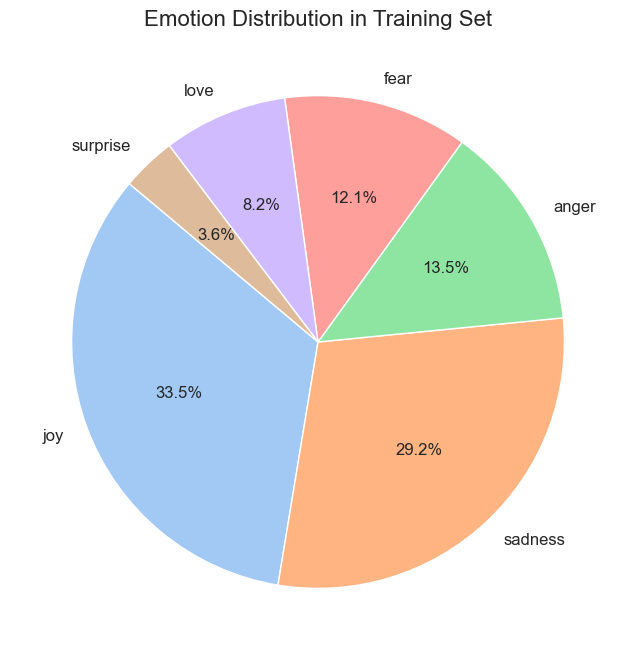

In [27]:
label_counts = train['label'].value_counts()

light_colors = sns.color_palette("pastel", n_colors=len(label_counts))

sns.set(style="whitegrid")

plt.figure(figsize=(8, 8))
plt.pie(
    label_counts, 
    labels=label_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=light_colors,
    textprops={'fontsize': 12}  
)
plt.title('Emotion Distribution in Training Set', fontsize=16)
plt.show()

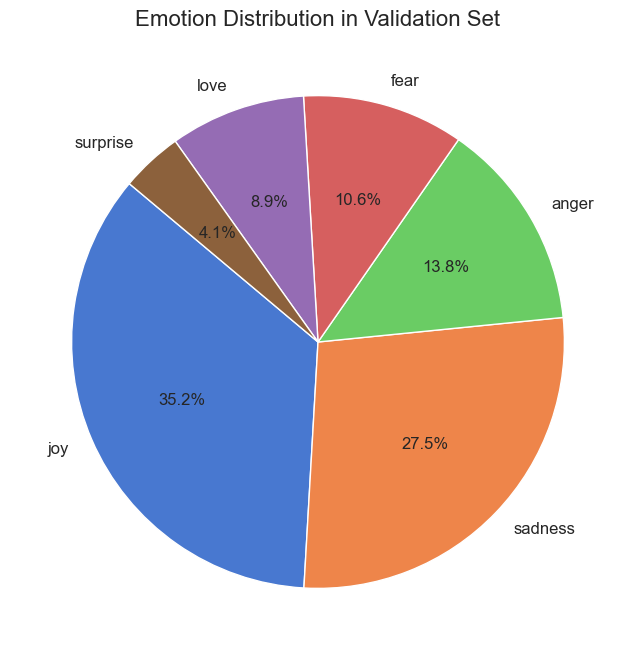

In [29]:
label_counts = val['label'].value_counts()

light_colors = sns.color_palette("muted", n_colors=len(label_counts))

sns.set(style="whitegrid")

plt.figure(figsize=(8, 8))
plt.pie(
    label_counts, 
    labels=label_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=light_colors,
    textprops={'fontsize': 12} 
)
plt.title('Emotion Distribution in Validation Set', fontsize=16)
plt.show()


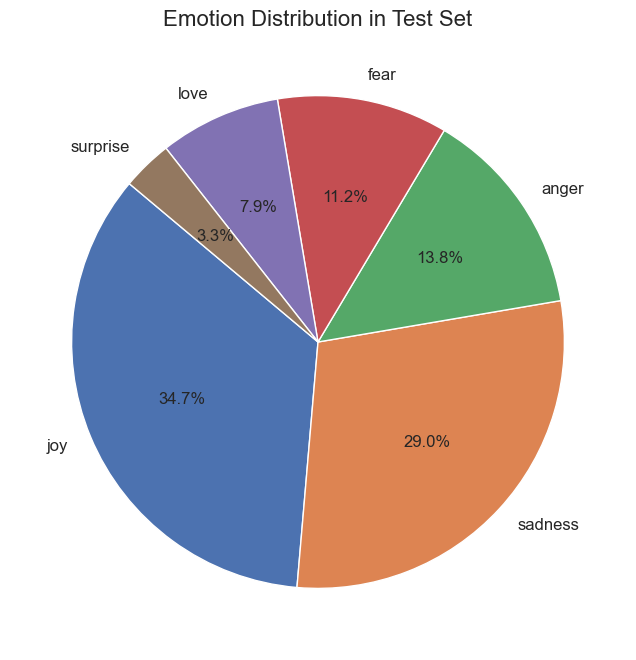

In [31]:
label_counts = test['label'].value_counts()

light_colors = sns.color_palette("deep", n_colors=len(label_counts))

sns.set(style="whitegrid")

plt.figure(figsize=(8, 8))
plt.pie(
    label_counts, 
    labels=label_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=light_colors,
    textprops={'fontsize': 12}  
)
plt.title('Emotion Distribution in Test Set', fontsize=16)
plt.show()


## Balancing Data
Removing love and suprise because of low percentages

label
joy        2200
sadness    2200
anger      2159
fear       1937
Name: count, dtype: int64


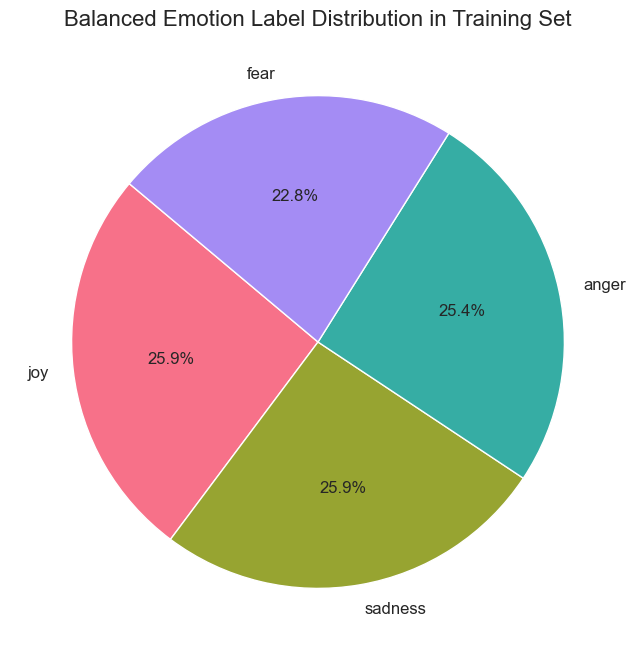

In [34]:
# Remove 'love' and 'surprise' labels from the training set
train = train[~train['label'].str.contains('love')]
train = train[~train['label'].str.contains('surprise')]

joy = train[train['label'] == 'joy'].sample(n=2200, random_state=20)
sadness = train[train['label'] == 'sadness'].sample(n=2200, random_state=20)
fear = train[train['label'] == 'fear'].sample(n=1937, random_state=20)
anger = train[train['label'] == 'anger'].sample(n=2159, random_state=20)

train_balanced = pd.concat([joy, sadness, fear, anger])

train_balanced = train_balanced.sample(frac=1, random_state=20).reset_index(drop=True)

print(train_balanced['label'].value_counts())

# Visualization
label_counts = train_balanced['label'].value_counts()
light_colors = sns.color_palette("husl", n_colors=len(label_counts))

sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(
    label_counts, 
    labels=label_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=light_colors,
    textprops={'fontsize': 12}
)
plt.title('Balanced Emotion Label Distribution in Training Set', fontsize=16)
plt.show()


Validation Set Distribution:
label
sadness    220
joy        220
anger      216
fear       193
Name: count, dtype: int64


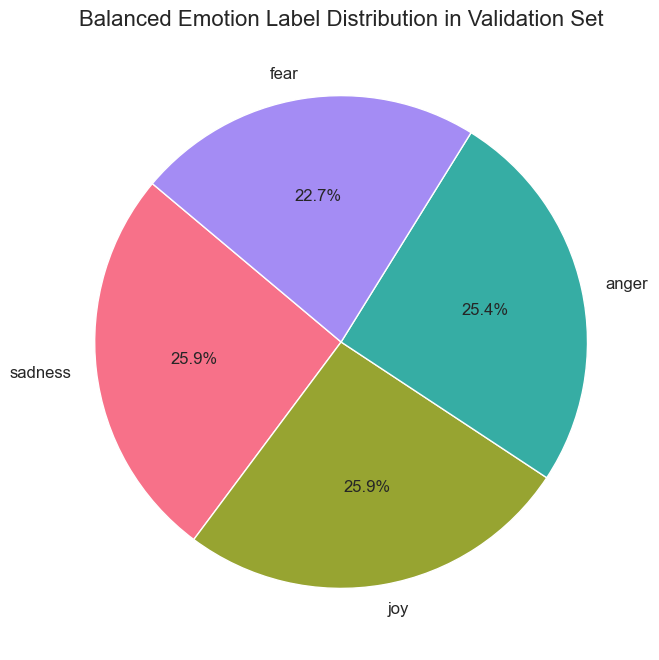

In [37]:
val = val[~val['label'].str.contains('love')]
val = val[~val['label'].str.contains('surprise')]

joy_val = val[val['label'] == 'joy'].sample(n=220, random_state=20)
sadness_val = val[val['label'] == 'sadness'].sample(n=220, random_state=20)
fear_val = val[val['label'] == 'fear'].sample(n=193, random_state=20)
anger_val = val[val['label'] == 'anger'].sample(n=216, random_state=20)

val_balanced = pd.concat([joy_val, sadness_val, fear_val, anger_val])

val_balanced = val_balanced.sample(frac=1, random_state=20).reset_index(drop=True)

print("Validation Set Distribution:")
print(val_balanced['label'].value_counts())

label_counts_val = val_balanced['label'].value_counts()
light_colors_val = sns.color_palette("husl", n_colors=len(label_counts_val))

plt.figure(figsize=(8, 8))
plt.pie(
    label_counts_val, 
    labels=label_counts_val.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=light_colors_val,
    textprops={'fontsize': 12}
)
plt.title('Balanced Emotion Label Distribution in Validation Set', fontsize=16)
plt.show()


Test Set Distribution:
label
sadness    220
joy        220
anger      216
fear       193
Name: count, dtype: int64


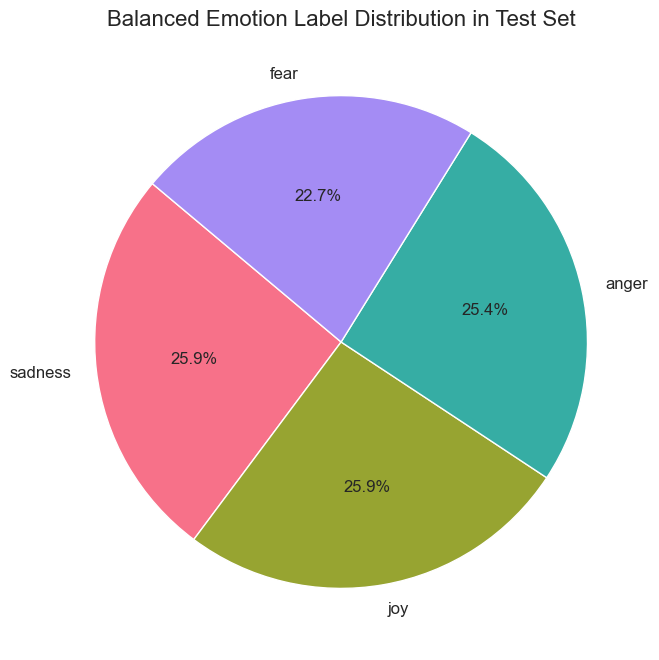

In [39]:
test = test[~test['label'].str.contains('love')]
test = test[~test['label'].str.contains('surprise')]

joy_test = test[test['label'] == 'joy'].sample(n=220, random_state=20)
sadness_test = test[test['label'] == 'sadness'].sample(n=220, random_state=20)
fear_test = test[test['label'] == 'fear'].sample(n=193, random_state=20)
anger_test = test[test['label'] == 'anger'].sample(n=216, random_state=20)

test_balanced = pd.concat([joy_test, sadness_test, fear_test, anger_test])

test_balanced = test_balanced.sample(frac=1, random_state=20).reset_index(drop=True)

print("Test Set Distribution:")
print(test_balanced['label'].value_counts())

label_counts_test = test_balanced['label'].value_counts()
light_colors_test = sns.color_palette("husl", n_colors=len(label_counts_test))

plt.figure(figsize=(8, 8))
plt.pie(
    label_counts_test, 
    labels=label_counts_test.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=light_colors_test,
    textprops={'fontsize': 12}
)
plt.title('Balanced Emotion Label Distribution in Test Set', fontsize=16)
plt.show()


## Data Splitting

In [42]:
tr_text = train['sentence']
tr_label = train['label']

val_text = val['sentence']
val_label = val['label']

ts_text = test['sentence']
ts_label = test['label']


print("Training Text Shape:", tr_text.shape)
print("Training Labels Shape:", tr_label.shape)

print("Validation Text Shape:", val_text.shape)
print("Validation Labels Shape:", val_label.shape)

print("Test Text Shape:", ts_text.shape)
print("Test Labels Shape:", ts_label.shape)


Training Text Shape: (14124,)
Training Labels Shape: (14124,)
Validation Text Shape: (1741,)
Validation Labels Shape: (1741,)
Test Text Shape: (1775,)
Test Labels Shape: (1775,)


## PreProcessing

In [45]:
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

In [47]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text) 
                            
sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=50) 
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=50)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=50)
ts_y = to_categorical(ts_label)

## Deep Learning Model

In [50]:
max_words = 10000
max_len = 50
embedding_dim = 32

In [94]:
input_layer = Input(shape=(max_len,))

# Branch 1
branch1 = Embedding(max_words, embedding_dim, input_length=max_len)(input_layer)
branch1 = Conv1D(64, 3, padding='same', activation='relu')(branch1)
branch1 = BatchNormalization()(branch1)
branch1 = ReLU()(branch1)
branch1 = Dropout(0.5)(branch1)
branch1 = GlobalMaxPooling1D()(branch1)

# Branch 2
branch2 = Embedding(max_words, embedding_dim, input_length=max_len)(input_layer)
branch2 = Conv1D(64, 3, padding='same', activation='relu')(branch2)
branch2 = BatchNormalization()(branch2)
branch2 = ReLU()(branch2)
branch2 = Dropout(0.5)(branch2)
branch2 = GlobalMaxPooling1D()(branch2)

# Concatenate branches
concatenated = Concatenate()([branch1, branch2])

# Fully connected layers
hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(4, activation='softmax')(dropout)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam',  
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])


model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 50, 32)    │    320,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 50, 32)    │    320,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 50, 64)    │      6,208 │ embedding_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 50, 64)    │      6,208 │ embedding_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_13 (ReLU)     │ (None, 50, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 50, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 50, 64)    │          0 │ re_lu_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 50, 64)    │          0 │ re_lu_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ dropout_17[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ dropout_18[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 128)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     16,512 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128)       │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4)         │        516 │ dropout_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 669,956 (2.56 MB)

 Trainable params: 669,700 (2.55 MB)

 Non-trainable params: 256 (1.00 KB)

In [96]:
batch_size = 256
epochs = 25

history = model.fit(tr_x, tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=(val_x, val_y))


Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - Precision: 0.3513 - Recall: 0.1449 - accuracy: 0.3448 - loss: 1.5171 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5032 - val_loss: 1.3707
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Precision: 0.7230 - Recall: 0.2844 - accuracy: 0.5543 - loss: 1.0881 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.8472 - val_loss: 1.3089
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Precision: 0.9050 - Recall: 0.7871 - accuracy: 0.8499 - loss: 0.4143 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.9357 - val_loss: 1.1357
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Precision: 0.9602 - Recall: 0.9439 - accuracy: 0.9521 - loss: 0.1482 - val_Precision: 1.0000 - val_Recall: 0.0207 - val_accuracy: 0.9512 - val_loss: 0.9826
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - Precision: 0.9761 - Recall: 0.9697 - accuracy: 0.9730 - loss: 0.0854 - val_Precision: 1

## Model Evaluation

In [99]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(ts_x, ts_y)


print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Precision: 0.9439 - Recall: 0.9400 - accuracy: 0.9417 - loss: 0.1997
Test Loss: 0.1806778907775879
Test Accuracy: 0.9476056098937988
Test Precision: 0.9496036171913147
Test Recall: 0.9447887539863586


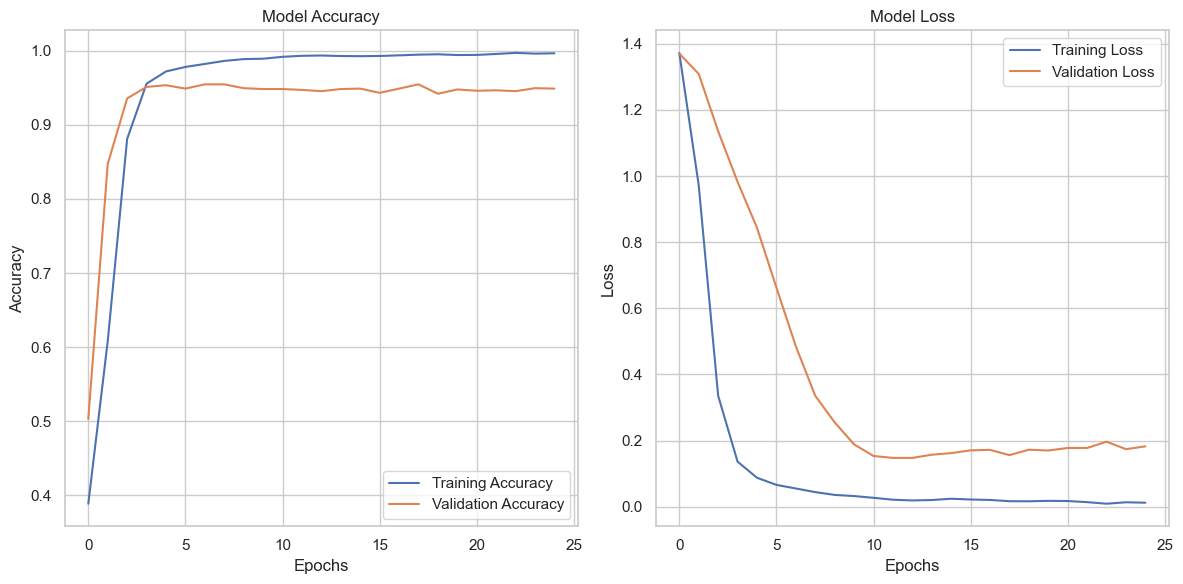

In [101]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


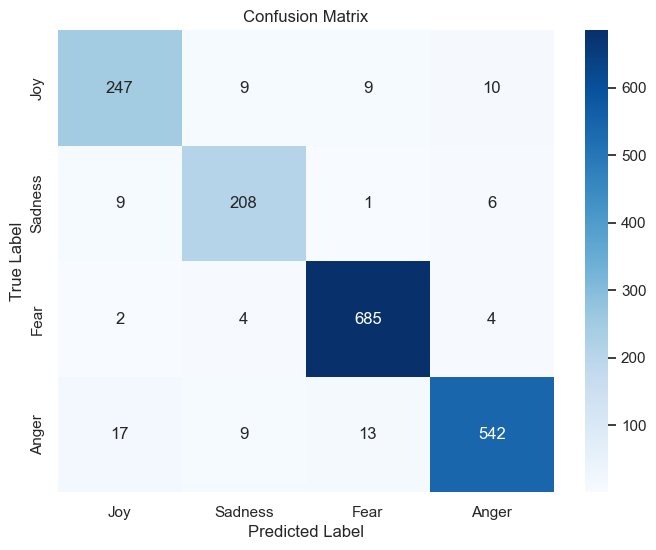

In [105]:
y_pred = model.predict(ts_x)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(ts_y, axis=1)


cm = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Joy', 'Sadness', 'Fear', 'Anger'], yticklabels=['Joy', 'Sadness', 'Fear', 'Anger'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [109]:
report = classification_report(y_true, y_pred_classes, target_names=['Joy', 'Sadness', 'Fear', 'Anger'])
print(report)

              precision    recall  f1-score   support

         Joy       0.90      0.90      0.90       275
     Sadness       0.90      0.93      0.92       224
        Fear       0.97      0.99      0.98       695
       Anger       0.96      0.93      0.95       581

    accuracy                           0.95      1775
   macro avg       0.93      0.94      0.93      1775
weighted avg       0.95      0.95      0.95      1775



## Saving Model 

In [182]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


model.save('nlp.keras')

## About 

This guided project focuses on classifying emotions from textual data, where the goal is to predict emotional states such as Joy, Sadness, Fear, Anger, and others from raw text input. The classification model was built using machine learning techniques to analyze and predict the emotion behind a given sentence.

The dataset consists of labeled text data with sentences expressing emotions, such as:
"I am feeling so happy today!" → Joy
"I feel very sad and lonely." → Sadness
"I'm so terrified!" → Fear
"I am so angry right now." → Anger
The data was split into training, validation, and test sets.


Text Normalization: Lowercasing, punctuation removal, and tokenization were applied to the text data.
Tokenization: Each word in the text was converted into a numerical representation using a tokenizer, creating a vocabulary.
Padding: Sequences of different lengths were padded to a consistent length to prepare the data for model input.

A Neural Network model was built to classify the text into emotion categories. The model's input consisted of preprocessed, tokenized, and padded text data.
Loss function: Categorical cross-entropy.
Optimizer: Adam optimizer.
Evaluation metrics: Accuracy, precision, recall, and F1-score were used to assess the model’s performance.


The model achieved high accuracy (approximately 95%) on the validation and test sets.
The F1-scores for individual classes were also strong, with Fear having the highest F1-score of 98%.
Precision and Recall metrics for all classes showed good balance, indicating the model performed well in identifying all emotions without bias.
Example predictions:
For the input "I am feeling so happy today!", the model predicted Joy with high confidence.
However, some misclassifications were observed, where certain texts like "happy" were incorrectly classified as Fear, indicating potential areas for further improvement.

Challenges & Solutions:

Class Imbalance: The model occasionally misclassified Fear due to class imbalance. This was addressed by applying class weights during training to give more importance to underrepresented classes.
Domain Consistency: Ensuring that the text preprocessing steps were consistent between training and prediction was crucial for reliable performance.


## Conclusion

The emotion classification model demonstrates strong potential for real-world applications in sentiment analysis, chatbots, and social media monitoring. Further improvements could include fine-tuning the model, using more advanced models like BERT for deeper language understanding, and balancing the class distribution for more accurate predictions.